This notebook shows the construction of simple feed-forward normalizing flows. 

In [1]:
from lib.toy_data import inf_train_gen
from lib.visualize_flow import plt_flow_2D
import matplotlib.pyplot as plt
from models import *
from timeit import default_timer as timer
import torch.nn as nn
%matplotlib inline

### Building your first normalizing flow
Let's create our first normalizing flow: an affine (masked) autoregressive flow.
Building such flow is very simple, you should first define the main building blocks of your flow. In this case these are the conditioner (autoregressive) and the normalizer (affine). Once this is done, you have to combine the conditioner and the normalizer into a flow step. You may do that multiple times if you want multiple steps in your flow, here we keep it simple and use only one step.
Once you have a list of normalizing flow steps you may create a normalizing flow by combining the list with a base distribution (often an isotropic Normal).

In [ ]:
conditioner = AutoregressiveConditioner(3, [250, 250, 250, 250], 2)
normalizer = AffineNormalizer()
flow_steps = [NormalizingFlowStep(conditioner, normalizer)]
flow = FCNormalizingFlow(flow_steps, NormalLogDensity())
simple_MLP = nn.Sequential(nn.Linear(2, 50), nn.ReLU(), 
                           nn.Linear(50, 150), nn.ReLU(),
                           nn.Linear(150, 250), nn.ReLU(),
                           nn.Linear(250, 150), nn.ReLU(),
                           nn.Linear(150, 50), nn.ReLU(),
                           nn.Linear(50, 1))

all_param = list(simple_MLP.parameters()) + list(flow.parameters())
opt = torch.optim.Adam(all_param, 1e-3, weight_decay=1e-5)


That's it, congratulations you built your first normalizing flow! ;)

Let's now check how we may train the flow on some data. We will create a function as we will train other flow architectures in the future, fortunately they all may be trained in the same way!

In [ ]:
def train_and_plot(flow, opt, toy="4gaussians", nb_epoch=1000):
    time_tot = 0.
    for epoch in range(nb_epoch):
        loss_tot = 0
        start = timer()
        
        # We get some data, (we place ourself in an ideal setting of infinite data).
        cur_x = torch.tensor(inf_train_gen(toy, batch_size=100))
        x_comp = simple_MLP(cur_x) + torch.randn(cur_x.shape[0], 1)/100.
        x_transf = torch.cat((x_comp, cur_x), 1)
        # We compute the log-likelihood as well as the base variable, check NormalizingFlow class for other possibilities
        ll, z = flow.compute_ll(x_transf)
        # Here we would like to maximize the log-likelihood of our model!
        loss = -ll.mean()
        opt.zero_grad()
        loss.backward()
        opt.step()

        end = timer()
        time_tot += end - start
        if epoch % 10 == 0:
            print("Approximate time left : {:2f}s - Loss last batch: {:4f}".format(time_tot/(epoch + 1) * (nb_epoch - (epoch + 1)), loss.item()),
                  end="\r", flush=True)

    # Let's check the result!
    fig = plt.figure(figsize=(18, 6))
    with torch.no_grad():
        ax = plt.subplot(1, 3, 1, aspect="equal")
        ax.set_title("Learned density")
        def compute_ll(x):
            x = torch.cat((simple_MLP(x), x), 1)
            ll, z = flow.compute_ll(x)
            return ll, z
        plt_flow_2D(compute_ll, ax, 100, range_xy=[[-4, 4], [-4, 4]])

        ax = plt.subplot(1, 3, 2, aspect="equal")
        ax.set_title("Generated samples")
        fake_samples = flow.invert(torch.randn(1000, 3)).detach().numpy()[:, :]
        ax.scatter(fake_samples[:, 1], fake_samples[:, 2], c=fake_samples[:, 0], marker=".")

        ax = plt.subplot(1, 3, 3, aspect="equal")
        ax.set_title("Real samples")
        samples = inf_train_gen(toy, batch_size=1000)
        ax.scatter(samples[:, 0], samples[:, 1], alpha=1., marker=".")


And now let us train this one-step affine autoregressive flow! 

###### for i in range(10000):
    plt.figure()
    train_and_plot(flow, opt, nb_epoch=1000)
    plt.show()

Mmmh not great! 

One step does not seem to be enough, let's build a 5-steps affine autoregressive flow. For that you may just reproduce the example above with multiple steps but you can just use one of our factories as follows:

In [ ]:
conditioner_type = AutoregressiveConditioner
conditioner_args = {"in_size": 3, "hidden": [50, 50, 50], "out_size": 2}

normalizer_type = AffineNormalizer
normalizer_args = {}

nb_flow = 3
flow = buildFCNormalizingFlow(nb_flow, conditioner_type, conditioner_args, normalizer_type, normalizer_args)
simple_MLP = nn.Sequential(nn.Linear(2, 50), nn.ReLU(), 
                           nn.Linear(50, 50), nn.ReLU(),
                           nn.Linear(50, 50), nn.ReLU(),
                           nn.Linear(50, 1))

all_param = list(simple_MLP.parameters()) + list(flow.parameters())
opt = torch.optim.Adam(all_param, 1e-3, weight_decay=1e-5)


The flow here is made of 5 steps, each of them being composed of an autoregressive conditioner and an affine normalizer (also denoted a transformer in the flow litterature). The parameters are not shared between flow steps!

In [ ]:
train_and_plot(flow, opt, nb_epoch=100)

These results are already better but modeling multi-modal distributions with affine normalizing flows is known to be impossible. A possible solution is to replace the affine transformations by monotonic ones, this has been proven to lead to universal density approximators. In the following example we use unconstrained monotonic neural networks to parameterize the monotonic transformation and combine it with an autoregressive conditioner.

In [70]:
conditioner = AutoregressiveConditioner(3, [100, 100, 100], 10)
normalizer = MonotonicNormalizer(integrand_net=[50, 50, 50], cond_size=10, nb_steps=50, solver="CCParallel")
flow_steps = [NormalizingFlowStep(conditioner, normalizer)]
flow = FCNormalizingFlow(flow_steps, NormalLogDensity())

simple_MLP = nn.Sequential(nn.Linear(2, 50), nn.ReLU(), 
                           nn.Linear(50, 50), nn.ReLU(),
                           nn.Linear(50, 50), nn.ReLU(),
                           nn.Linear(50, 1))

all_param = list(simple_MLP.parameters()) + list(flow.parameters())
opt = torch.optim.Adam(all_param, 1e-3, weight_decay=1e-5)

In [71]:
train_and_plot(flow, opt, nb_epoch=100)

NameError: name 'train_and_plot' is not defined

We have only shown how to use autoregressive conditioners, however you may find other famous conditioners in the library such as coupling conditioners or graphical conditioners.

In [102]:
conv1 = nn.Conv2d(1, 5, 3, 1, 1)
x = conv1(torch.randn(1, 1, 28, 28))
conv2 = nn.Conv2d(5, 5, 3, 1, 1)
x = conv2(x)
pool2 = nn.MaxPool2d(2)
x = pool2(x)

conv3 = nn.Conv2d(5, 1, 3, 1, 1)
x = conv3(x)
pool3 = nn.MaxPool2d(2)
x = pool3(x)
x.shape

torch.Size([1, 1, 7, 7])

In [206]:
class MNISTNF(nn.Module):
    def __init__(self):
        super(MNISTNF, self).__init__()
        
        self.cond1 = nn.Conv2d(1, 5, 3, 1, 1)   
        conditioner = AutoregressiveConditioner(1, [250, 250, 250], 2, 5)
        normalizer = AffineNormalizer()
        flow_steps = [NormalizingFlowStep(conditioner, normalizer)]
        self.flow_1 = FCNormalizingFlow(flow_steps, NormalLogDensity()) # This will be 1D conditionning (probably not good)
        
        conv2 = nn.Conv2d(5, 5, 3, 1, 1)
        pool2 = nn.MaxPool2d(2)
        self.cond2 = nn.Sequential(conv2, pool2)
        conditioner = AutoregressiveConditioner(5, [250, 250, 250], 2, 5)
        normalizer = AffineNormalizer()
        flow_steps = [NormalizingFlowStep(conditioner, normalizer)]
        self.flow_2 = FCNormalizingFlow(flow_steps, NormalLogDensity())
        
        conv3 = nn.Conv2d(5, 1, 3, 1, 1)
        pool3 = nn.MaxPool2d(2)
        self.cond3 = nn.Sequential(conv3, pool3)
        conditioner = AutoregressiveConditioner(5, [250, 250, 250], 2, 1)
        normalizer = AffineNormalizer()
        flow_steps = [NormalizingFlowStep(conditioner, normalizer)]
        self.flow_3 = FCNormalizingFlow(flow_steps, NormalLogDensity())
        
        fc1 = nn.Linear(49, 150)
        fc2 = nn.Linear(150, 150)
        fc3 = nn.Linear(150, 50)
        fc4 = nn.Linear(50, 10)
        self.cond4 = nn.Sequential(fc1, nn.ReLU(), fc2, nn.ReLU(), fc3, nn.ReLU(), fc4)
        conditioner = AutoregressiveConditioner(49, [250, 250, 250], 2, 10)
        normalizer = AffineNormalizer()
        flow_steps = [NormalizingFlowStep(conditioner, normalizer)]
        self.flow_4 = FCNormalizingFlow(flow_steps, NormalLogDensity())
        
        conditioner = AutoregressiveConditioner(10, [250, 250, 250], 2)
        normalizer = AffineNormalizer()
        flow_steps = [NormalizingFlowStep(conditioner, normalizer)]
        self.flow_5 = FCNormalizingFlow(flow_steps, NormalLogDensity())
        

    def forward(self, x, context=None):
        b_size = x.shape[0]
        
        cond1 = self.cond1(x) 
        cond1 += torch.randn(cond1.shape)/1000.
        cond1_reshaped = cond1.permute(0, 2, 3, 1).contiguous().view(-1, 5)
        x1 = x.permute(0, 2, 3, 1).contiguous().view(-1, 1) #[b_size, 1, 28, 28] -> [b_size * 28 * 28, 1]
        log_prob1, z1 = self.flow_1.compute_ll(x1, context=cond1_reshaped)
        log_prob1 = log_prob1.view(b_size, -1).sum(1)#[b_size, 1 * 28 * 28] -> [b_size]
        
        cond2 = self.cond2(cond1)#[b_size, 1, 28, 28] -> [b_size, 5, 14, 14]
        cond2 += torch.randn(cond2.shape)/1000.
        cond2_reshaped = cond2.view(cond2.shape[0], -1).unsqueeze(2).expand(-1, -1, 2).contiguous().view(cond2.shape[0], -1, 1, cond2.shape[3]*2).expand(-1, -1, 2, -1).permute(0, 2, 3, 1).contiguous().view(-1, 5)
            #[b_size, 1, 14, 14] -> [b_size, 5, 14, 14] -> [b_size, 5, 28, 28] -> [b_size * 28 * 28, 5]
        x2 = cond1.permute(0, 2, 3, 1).contiguous().view(-1, 5) #[b_size, 5, 28, 28] -> [b_size * 28 * 28, 5]
        log_prob2, z2 = self.flow_2.compute_ll(x2, cond2_reshaped)
        log_prob2 = log_prob2.view(b_size, -1).sum(1) #[b_size * 28 * 28, 5] -> [b_size,  28 * 28 * 5] -> [b_size]
        
        cond3 = self.cond3(cond2) #[b_size, 5, 14, 14] -> [b_size, 1, 7, 7]
        cond3 += torch.randn(cond3.shape)/1000.
        cond3_reshaped = cond3.view(cond3.shape[0], -1).unsqueeze(2).expand(-1, -1, 2).contiguous().view(cond3.shape[0], -1, 1, cond3.shape[3]*2).expand(-1, -1, 2, -1).permute(0, 2, 3, 1).contiguous().view(-1, 1)
            #[b_size, 1, 7, 7] -> ... -> [b_size, 14 * 14 * 1]
        x3 = cond2.permute(0, 2, 3, 1).contiguous().view(-1, 5) #[b_size, 5, 14, 14] -> [b_size * 14 * 14, 5]
        log_prob3, z3 = self.flow_3.compute_ll(x3, cond3_reshaped) 
        log_prob3 = log_prob3.view(b_size, -1).sum(1) #[b_size * 14 * 14, 5] -> ... -> [b_size]
        
        x4 = cond3.view(-1, 49)
        cond4 = self.cond4(x4)
        cond4 += torch.randn(cond4.shape)/1000.
        log_prob4, z4 = self.flow_4.compute_ll(x4, cond4)
        log_prob4 = log_prob4.view(b_size, -1).sum(1)
        
        x5 = cond4
        log_prob5, z5 = self.flow_5.compute_ll(x5)
        log_prob5 = log_prob5.view(b_size, -1).sum(1)
                
            
        z_tot = torch.cat((z1.view(b_size, -1), z2.view(b_size, -1), z3.view(b_size, -1), z4.view(b_size, -1),
                           z5.view(b_size, -1)), 1)
        log_prob = log_prob1 + log_prob2 + log_prob3 + log_prob4 + log_prob5
        return log_prob, z_tot
                          
    def invert(self, z_tot):
        b_size = z_tot.shape[0]
        
        z5 = z_tot[:, -10:]
        x5 = self.flow_5.invert(z5)

        z4 = z_tot[:, -59:-10]
        cond4 = x5        
        x4 = self.flow_4.invert(z4, cond4)

        z3 = z_tot[:, -59-(5*14*14):-59]
        cond3_reshaped = x4.view(b_size, -1).unsqueeze(2).expand(-1, -1, 2).contiguous().view(x4.shape[0], -1, 1, 14).expand(-1, -1, 2, -1).contiguous().view(-1, 1)
        x3 = self.flow_3.invert(z3.reshape(cond3_reshaped.shape[0], 5), cond3_reshaped)

        z2 = z_tot[:, -59-(5*14*14)-(5*28*28):-59-(5*14*14)]
        cond2 = x3.view(b_size, 14, 14, 5).permute(0, 3, 1, 2)
        cond2_reshaped = cond2.reshape(cond2.shape[0], -1).unsqueeze(2).expand(-1, -1, 2).reshape(cond2.shape[0], -1, 1, cond2.shape[3]*2).expand(-1, -1, 2, -1).permute(0, 2, 3, 1).reshape(-1, 5)
        x2 = self.flow_2.invert(z2.reshape(cond2_reshaped.shape[0], 5), cond2_reshaped)

        z1 = z_tot[:, :-59-(5*14*14)-(5*28*28)]
        cond1 = x2.view(b_size, 28, 28, 5).permute(0, 3, 1, 2)
        cond1_reshaped = cond1.permute(0, 2, 3, 1).contiguous().view(-1, 5)
        x1 = self.flow_1.invert(z1.reshape(cond1_reshaped.shape[0], 1), context=cond1_reshaped)
        x = x1.view(b_size, 28, 28, 1).permute(0, 3, 1, 2)
        
        return x
    
    def sample(self, nb_samples=1):
        x5 = self.flow_5.invert(torch.randn(nb_samples, 10))

        cond4 = x5        
        x4 = self.flow_4.invert(torch.randn(nb_samples, 49), cond4)

        cond3_reshaped = x4.view(nb_samples, -1).unsqueeze(2).expand(-1, -1, 2).contiguous().view(x4.shape[0], -1, 1, 14).expand(-1, -1, 2, -1).contiguous().view(-1, 1)
        x3 = self.flow_3.invert(torch.randn(cond3_reshaped.shape[0], 5), cond3_reshaped)

        cond2 = x3.view(nb_samples, 14, 14, 5).permute(0, 3, 1, 2)
        cond2_reshaped = cond2.reshape(cond2.shape[0], -1).unsqueeze(2).expand(-1, -1, 2).reshape(cond2.shape[0], -1, 1, cond2.shape[3]*2).expand(-1, -1, 2, -1).permute(0, 2, 3, 1).reshape(-1, 5)
        x2 = self.flow_2.invert(torch.randn(cond2_reshaped.shape[0], 5), cond2_reshaped)

        cond1 = x2.view(nb_samples, 28, 28, 5).permute(0, 3, 1, 2)
        cond1_reshaped = cond1.permute(0, 2, 3, 1).contiguous().view(-1, 5)
        x1 = self.flow_1.invert(torch.randn(cond1_reshaped.shape[0], 1), context=cond1_reshaped)
        x = x1.view(nb_samples, 28, 28, 1).permute(0, 3, 1, 2)
        
        return x
        
        

In [207]:
import torchvision

In [208]:
batch_size_train = 100
batch_size_test = 100
n_epochs = 100
log_interval = 10

In [209]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [210]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [211]:
net = MNISTNF()
opt = torch.optim.Adam(net.parameters(), 1e-3, weight_decay=1e-5)


In [212]:
def train(epoch):
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        opt.zero_grad()
        ll, _ = net(data)
        loss = -ll.mean()
        loss.backward()
        opt.step()
        
        if batch_idx % log_interval == 0:
            plt.figure()
            plt.imshow(net.sample().view(28, 28).detach().numpy())
            plt.show()
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(net.state_dict(), 'model.pth')
            torch.save(opt.state_dict(), 'optimizer.pth')

In [213]:
def test():
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output, _ = net(data)
            loss = output.mean()
            test_loss += loss.item()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}\n'.format(test_loss))


Test set: Avg. loss: -71.9050



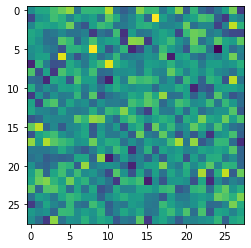

Train Epoch: 1 [0/60000 (0%)]	Loss: 7189.866211


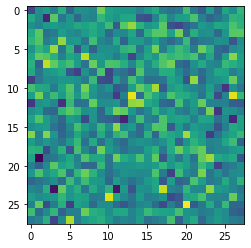

Train Epoch: 1 [1000/60000 (2%)]	Loss: 6082.218262


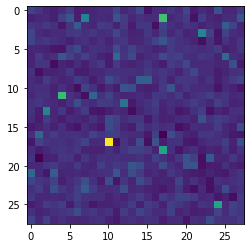

Train Epoch: 1 [2000/60000 (3%)]	Loss: 4329.401855


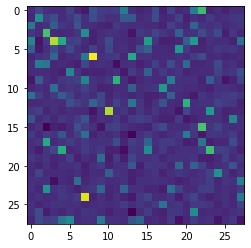

Train Epoch: 1 [3000/60000 (5%)]	Loss: 2484.430908


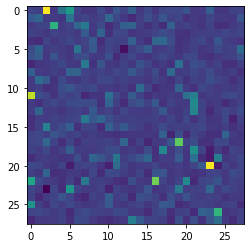

Train Epoch: 1 [4000/60000 (7%)]	Loss: 928.101746


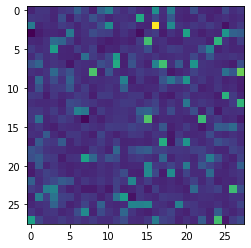

Train Epoch: 1 [5000/60000 (8%)]	Loss: -628.521973


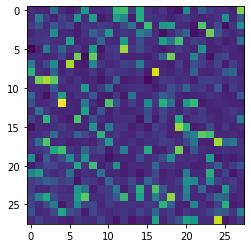

Train Epoch: 1 [6000/60000 (10%)]	Loss: -2111.396973


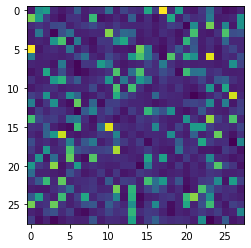

Train Epoch: 1 [7000/60000 (12%)]	Loss: -3310.187500


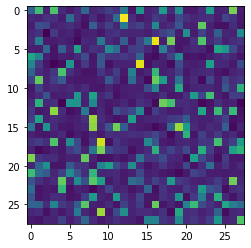

Train Epoch: 1 [8000/60000 (13%)]	Loss: -4040.941650


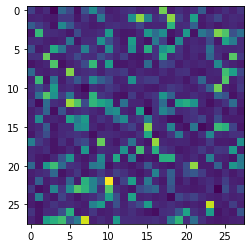

Train Epoch: 1 [9000/60000 (15%)]	Loss: -4864.085449


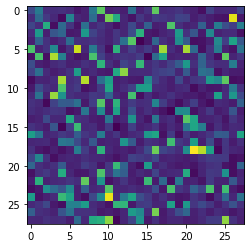

Train Epoch: 1 [10000/60000 (17%)]	Loss: -5527.082031


In [ ]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()